In [1]:
import os
import spyt
import numpy as np
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import confusion_matrix
from itertools import combinations
from scipy.stats import fisher_exact
import pyspark.sql.functions as F 
import pyspark.sql.types as T 
from pyspark.sql.functions import col, lit, broadcast
from pyspark.sql.window import Window
from clan_tools.secrets.Vault import Vault
from clan_tools.data_adapters.YTAdapter import YTAdapter


pd.set_option('display.max.rows', 100)
pd.set_option("display.max_columns", 50)
DEFAULT_SPARK_CONF = {
    "spark.executor.memory": "5G",
    "spark.executor.cores": 2,
    "spark.sql.session.timeZone": "UTC",
    "spark.dynamicAllocation.maxExecutors": 6,
    "spark.dynamicAllocation.enabled":True,
    "spark.sql.autoBroadcastJoinThreshold":-1,
    "spark.cores.min":12,
    "spark.driver.memory": "4G",
    "spark.executor.instances":6,
}

In [2]:
spark = spyt.connect(spark_conf_args=DEFAULT_SPARK_CONF)
spyt.info(spark)

2021-07-16 17:01:33,319 - INFO - spyt.client - SPYT Cluster version: 3.0.1-1.6.2+yandex
2021-07-16 17:01:33,321 - INFO - spyt.client - SPYT library version: 1.3.5


In [3]:
Vault().get_secrets()
yt = YTAdapter().yt

#### Read all available tables (with awesome tablenames)

## AB-test

#### Acquisition cube

In [4]:
# acquisition cube

cube = (
    spark
    .read
    .yt("//home/cloud_analytics/cubes/acquisition_cube/cube")
)

#### Individual accounts

In [5]:
# # берем статусы из остальных источников - так как текущий учитывает актульаное состояние на данный момент

# individual_accs = (
#     cube
#     .filter(col("event")=="ba_created")
#     .filter(col("ba_usage_status")!="service")
#     .filter(col("ba_person_type") == "individual")
#     .select("billing_account_id", 
#             "ba_usage_status_actual",
#             col("first_first_trial_consumption_datetime").alias("first_trial_dt"), 
#             col("first_first_paid_consumption_datetime").alias("first_paid_dt"))
#     .distinct()
# )

#### Leads in *'ab\_test'*

In [6]:
# таблица с историей лидов от модели trial to paid - заносятся обе группы: контрольная и тестовая
# оставляем только тех, кого модель отмечала как индивидуальных пользователей

ab_test_history = (
    spark
    .read
    .yt("//home/cloud_analytics/scoring_v2/ab_test")
    .filter(col("lead_source_description")=="Client is Individual")
    .select(col("ba_id").alias("billing_account_id"), "group", "scoring_date")
)
ab_test_history.printSchema()
display(ab_test_history.limit(5).toPandas())
ab_test_history.groupby("group").count().show()

root
 |-- billing_account_id: string (nullable = true)
 |-- group: string (nullable = true)
 |-- scoring_date: string (nullable = true)



,billing_account_id,group,scoring_date
0,dn200hnqlbeu46sq6mum,test,2021-06-13
1,dn200kfr7mo6fgbrbuqo,test,2021-04-21
2,dn200l130eaakl0iqo2q,test,2021-07-08
3,dn200l3gvc3ladvqaeck,control,2021-06-08
4,dn201fseb5vgsbujdnpp,test,2021-04-14


+-------+-----+
|  group|count|
+-------+-----+
|   test| 2008|
|control| 1312|
+-------+-----+



#### Leads CRM statuses

In [7]:
# вспомогательные функции
def max_by(x, y):
    return F.expr(f'max_by({x}, {y})')
def min_by(x, y):
    return F.expr(f'min_by({x}, {y})')

# из базы CRM отбираем лидов модели trial to paid
# оставляем последний статус лида и дату присвоения этого статуса
leads_statuses = (
    spark
    .read
    .yt("//home/cloud_analytics/dwh/cdm/dm_crm_leads")
    .filter(col("lead_source")=="trial")
    .filter(col("lead_source_description")=="Client is Individual")
    .groupby("billing_account_id")
    .agg(
        F.to_date(F.to_timestamp(F.max("date_modified"))).alias("date_modified"),
        max_by("status", "date_modified").alias("lead_status")
    )
    .filter(~col("billing_account_id").isNull())
    .filter(F.length(col("billing_account_id"))<21)
    .filter(~col("billing_account_id").isin(["-", "admin", "дубликат", "billing_id"]))
)
print("Count:", leads_statuses.count())
leads_statuses.limit(10).show()

Count: 12045
+--------------------+-------------+-----------+
|  billing_account_id|date_modified|lead_status|
+--------------------+-------------+-----------+
|dn20062cndjuoar4rqbm|   2021-01-20|   Recycled|
|dn2009td5nf14bqm81es|   2021-02-17|   Recycled|
|dn200es4lva0ur715bfh|   2020-07-03|   Recycled|
|dn200hjvg2sa7oplcpr9|   2021-02-24|   Recycled|
|dn200hnqlbeu46sq6mum|   2021-06-29|   Recycled|
|dn200kfr7mo6fgbrbuqo|   2021-04-22|  Converted|
|dn200l130eaakl0iqo2q|   2021-07-09|   Assigned|
|dn200magdh8b7kcid08d|   2021-06-09|   Recycled|
|dn200q99f9tqai6aqtdn|   2020-09-30|   Recycled|
|dn200qhvf69m2shb2bku|   2020-07-03|   Recycled|
+--------------------+-------------+-----------+



#### Leads from model

In [8]:
leads_ab = ab_test_history.join(leads_statuses, on="billing_account_id", how="left")

print("Test")
leads_ab.filter(col("group")=="test").show(3)
print("\nControl")
leads_ab.filter(col("group")=="control").show(3)
leads_ab[["billing_account_id"]].count()

Test
+--------------------+-----+------------+-------------+-----------+
|  billing_account_id|group|scoring_date|date_modified|lead_status|
+--------------------+-----+------------+-------------+-----------+
|dn200hnqlbeu46sq6mum| test|  2021-06-13|   2021-06-29|   Recycled|
|dn200kfr7mo6fgbrbuqo| test|  2021-04-21|   2021-04-22|  Converted|
|dn200l130eaakl0iqo2q| test|  2021-07-08|   2021-07-09|   Assigned|
+--------------------+-----+------------+-------------+-----------+
only showing top 3 rows


Control
+--------------------+-------+------------+-------------+-----------+
|  billing_account_id|  group|scoring_date|date_modified|lead_status|
+--------------------+-------+------------+-------------+-----------+
|dn200l3gvc3ladvqaeck|control|  2021-06-08|         null|       null|
|dn201o7de3i2c8891shc|control|  2021-04-15|         null|       null|
|dn201shtlfbqhrt6btlh|control|  2021-05-25|         null|       null|
+--------------------+-------+------------+-------------+--------

3320

In [9]:
# # Проверить что биллинг-акаунтов из контрольной группы нет в crm-ной базе

# leads_ab.filter(col("group")=="control").filter(~col("lead_status").isNull()).show()

In [10]:
# # Есть ли биллинг-аккаунты, которые поменяли статус с индивидуального на компанию с момента скоринга

# tt = (
#     leads_ab
#     .join(cube.select(
#               "billing_account_id",
#               F.to_date("event_time").alias("scoring_date"),
#               "ba_person_type", "ba_person_type_actual"
#           ), 
#           on=["billing_account_id", "scoring_date"], 
#           how="left"
#     )
# )

# # test 1
# tt.filter(col("ba_person_type")!=col("ba_person_type_actual")).show()

# # test 2
# tt.groupby("billing_account_id")\
#     .agg(F.countDistinct("ba_person_type").alias("cnt"))\
#     .groupby("cnt").count().show()

#### Consumption

In [11]:
consumption = (
    cube
    .filter(col("event")=="day_use")
    .select("billing_account_id", 
            F.to_date("event_time").alias("event_date"),
            "event_time",
            "real_consumption",
            "br_cost",
            "ba_person_type", 
            "ba_person_type_actual", 
            "ba_usage_status_actual", 
            col("first_first_trial_consumption_datetime").alias("first_trial_dt"), 
            col("first_first_paid_consumption_datetime").alias("first_paid_dt")
           )
    .groupBy("billing_account_id", "event_date")
    .agg(
        F.sum("real_consumption").alias("real_consumption"),
        F.sum("br_cost").alias("br_cost"),
        min_by("ba_person_type", "event_time").alias("ba_person_type"),
        max_by("ba_person_type_actual", "event_time").alias("ba_person_type_actual"),
        max_by("ba_usage_status_actual", "event_time").alias("ba_usage_status_actual"),
        max_by("first_trial_dt", "event_time").alias("first_trial_dt"),
        max_by("first_paid_dt", "event_time").alias("first_paid_dt")
    )
    .cache()
)
consumption.limit(3).toPandas()

,billing_account_id,event_date,real_consumption,br_cost,ba_person_type,ba_person_type_actual,ba_usage_status_actual,first_trial_dt,first_paid_dt
0,dn2000o2g9kv69el386u,2019-12-09,0.0,39.701875,individual,individual,trial,2019-07-17 13:59:59,0000-00-00 00:00:00
1,dn20020ule0tofnadk2f,2019-11-11,0.0,7.444102,individual,individual,trial,2019-09-05 17:59:59,0000-00-00 00:00:00
2,dn2002uqiske4gmnm4t8,2020-10-16,0.0,51.038956,individual,individual,trial,2020-10-12 18:59:59,0000-00-00 00:00:00


#### Calls

In [12]:
calls = (
    spark
    .read
    .yt("//home/cloud_analytics/dwh/cdm/dm_crm_calls")
    .filter(col("call_status")!="Planned")
    .select(F.coalesce(col("lead_ba_id"), 
                       col("opp_acc_ba_id"), 
                       col("acc_ba_id")).alias("billing_account_id"), 
            "call_status", lit(1).alias("had_call"))
    .distinct()
    .filter(~col("billing_account_id").isNull())
)
print("Count:", calls.count())
calls.limit(3).toPandas()

Count: 37938


,billing_account_id,call_status,had_call
0,dn2p1grtsu7f3ld5k0nh,not_reached,1
1,dn233hgb99qqev8ppmm3,not_reached,1
2,dn22tacf2mgjn8k6fv53,Not Held,1


#### Calls histogram

In [13]:
calls_hist = (
    spark
    .read
    .yt("//home/cloud_analytics/dwh/cdm/dm_crm_calls")
    .filter(col("call_status")!="Planned")
    .select(F.coalesce(col("lead_ba_id"), 
                       col("opp_acc_ba_id"), 
                       col("acc_ba_id")).alias("billing_account_id"),
            F.to_timestamp("call_date_start").alias("call_dt"),
            "call_status")
    .join(
        leads_ab
        .filter(col("group")=="test")
        .select("billing_account_id")
        .distinct(),
        on="billing_account_id"
    )
    .cache()
)

calls_first_held = (
    calls_hist
    .groupby("billing_account_id")
    .agg(
        F.min(F.when(col("call_status")=="Held", col("call_dt"))).alias("first_held")
    )
    .filter(~col("first_held").isNull())
)

calls_hist = (
    calls_hist
    .join(calls_first_held, on="billing_account_id")
    .groupby("billing_account_id")
    .agg(
        F.first(col("first_held")).alias("first_held"),
        F.sum((col("call_dt")<col("first_held")).cast("int")).alias("calls_before_first_held"),
        F.sum((col("call_dt")>col("first_held")).cast("int")).alias("calls_after_first_held")
    )
)

pd_calls_hist = calls_hist.toPandas()
pd_calls_hist.head()

,billing_account_id,first_held,calls_before_first_held,calls_after_first_held
0,dn200kfr7mo6fgbrbuqo,2021-04-22 12:05:00,0,0
1,dn201fseb5vgsbujdnpp,2021-04-29 10:31:00,0,0
2,dn203le14ti42u6ukqq4,2021-07-09 13:56:00,0,0
3,dn205ra4471h9l453chs,2021-06-30 14:21:00,0,0
4,dn207uds7unc7jr04eth,2021-05-17 14:30:00,1,0


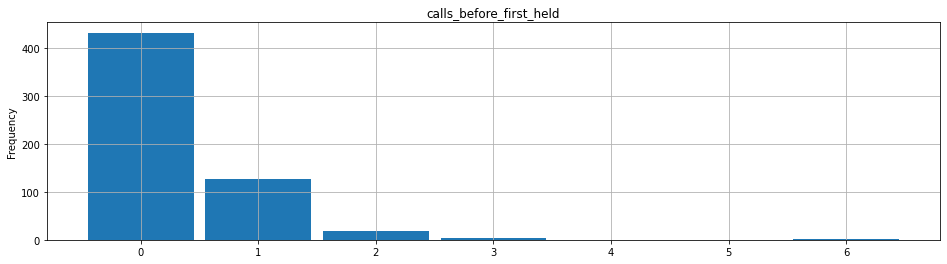

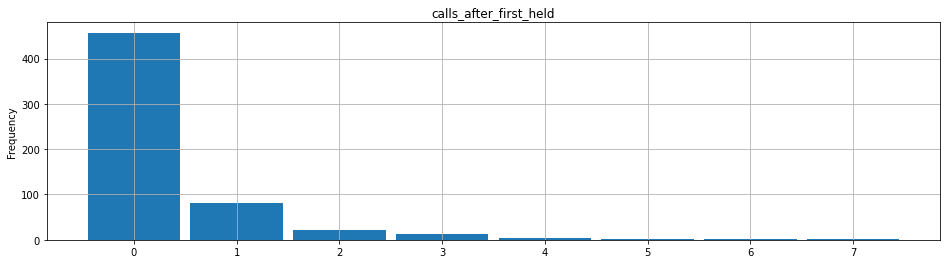

In [14]:
def plot_hist(pd_series):
    pd_series = pd_series.copy()
    fig, ax = plt.subplots(figsize=(16,4))
    pd_series.plot.hist(
        ax=ax, 
        bins=pd_series.max()-pd_series.min()+1, 
        range=(pd_series.min()-0.5, pd_series.max()+0.5), 
        rwidth=0.9
    )
    plt.title(pd_series.name)
    plt.grid()
    plt.show()
    
plot_hist(pd_calls_hist["calls_before_first_held"])
plot_hist(pd_calls_hist["calls_after_first_held"])

#### Final dataset

In [15]:
final_dts = (
    consumption
    .join(leads_ab, on="billing_account_id")
#     .join(individual_accs, on="billing_account_id")
    .join(calls, on="billing_account_id", how="left")
    .filter(col("scoring_date")<"2021-06-29")
    .filter(col("event_date")<="2021-06-30")
    .filter(col("event_date")>=col("scoring_date")) 
    .filter((col("had_call")==1) & (col("group")=="test") |
            (col("had_call").isNull() & (col("group")=="control")))
    .cache()
)
final_dts.limit(5).toPandas()

,billing_account_id,event_date,real_consumption,br_cost,ba_person_type,ba_person_type_actual,ba_usage_status_actual,first_trial_dt,first_paid_dt,group,scoring_date,date_modified,lead_status,call_status,had_call
0,dn20va6l7guh9cf6af5s,2021-06-08,0.0,28.412631,individual,individual,trial,2021-05-14 11:59:59,0000-00-00 00:00:00,test,2021-05-28,2021-06-01,Recycled,Held,1
1,dn20va6l7guh9cf6af5s,2021-06-26,0.0,28.398829,individual,individual,trial,2021-05-14 11:59:59,0000-00-00 00:00:00,test,2021-05-28,2021-06-01,Recycled,Held,1
2,dn20va6l7guh9cf6af5s,2021-06-11,0.0,28.401882,individual,individual,trial,2021-05-14 11:59:59,0000-00-00 00:00:00,test,2021-05-28,2021-06-01,Recycled,Held,1
3,dn20va6l7guh9cf6af5s,2021-06-19,0.0,28.403952,individual,individual,trial,2021-05-14 11:59:59,0000-00-00 00:00:00,test,2021-05-28,2021-06-01,Recycled,Held,1
4,dn20va6l7guh9cf6af5s,2021-06-15,0.0,28.413843,individual,individual,trial,2021-05-14 11:59:59,0000-00-00 00:00:00,test,2021-05-28,2021-06-01,Recycled,Held,1


In [16]:
# final_dts.select("billing_account_id", "group").distinct().groupby("group").count().show()

# final_dts[["billing_account_id"]].distinct().count()

# final_dts.groupby("lead_status").count().show()

#### Cohorts and Weeks info

In [17]:
min_sc_dt = final_dts.agg(F.min(col("scoring_date"))).collect()[0][0]
def cohort_num():
    return F.floor(F.datediff(col("scoring_date"), lit(min_sc_dt))/7)+1

cohorts = (
    final_dts
    .withColumn("cohort", cohort_num())
    .groupby("cohort")
    .agg(F.min("scoring_date").alias("coh_from_date"), 
         F.date_add(F.min("scoring_date"), 6).alias("coh_to_date"), 
         F.countDistinct("billing_account_id").alias("coh_ba_cnt"))
)

cohorts.sort("cohort").show()

+------+-------------+-----------+----------+
|cohort|coh_from_date|coh_to_date|coh_ba_cnt|
+------+-------------+-----------+----------+
|     1|   2021-04-13| 2021-04-19|       209|
|     2|   2021-04-20| 2021-04-26|       134|
|     3|   2021-04-27| 2021-05-03|       268|
|     4|   2021-05-04| 2021-05-10|       218|
|     5|   2021-05-11| 2021-05-17|       167|
|     6|   2021-05-18| 2021-05-24|       174|
|     7|   2021-05-25| 2021-05-31|       152|
|     8|   2021-06-01| 2021-06-07|       152|
|     9|   2021-06-08| 2021-06-14|       126|
|    10|   2021-06-15| 2021-06-21|       128|
|    11|   2021-06-22| 2021-06-28|       129|
+------+-------------+-----------+----------+



In [18]:
# final_dts.printSchema()

# final_dts.groupby("call_status").count().show()

#### Final dataset grouped by BA

In [19]:
# # посмотреть на пересечение между статусом paid, реальным потреблением исходя из биллинга 
# # и наличием даты перехода в платное потребление

# test = (
#     final_dts
#     .groupby("billing_account_id")
#     .agg(
#         (F.sum("real_consumption")>0).alias("real_consumption_sum_greater_than_zero"),
#         (max_by("ba_usage_status_actual", "event_date")=="paid").alias("ba_usage_status_actual_is_paid"),
#         (max_by("first_paid_dt", "event_date")!="0000-00-00 00:00:00").alias("first_paid_dt_exists"),
#     )
# )


# pd_test = test.toPandas()
# display(pd_test.head())

# labels = [True, False]
# for cols in combinations(pd_test.columns[1:], 2):
#     display(pd.DataFrame(confusion_matrix(pd_test[cols[0]],
#                                           pd_test[cols[1]],
#                                           labels=labels),
#                          columns=pd.MultiIndex.from_product([[cols[0]],labels]),
#                          index=pd.MultiIndex.from_product([[cols[1]],labels])))

In [20]:
def period():
    return F.datediff(lit("2021-06-30"), F.min(col("scoring_date")))

# потребление 7 последних дней если оно есть
def last_week_consumption():
    res = F.when(col("event_date")>"2021-06-23", col("real_consumption"))
    return res

final_dts_by_ba = (
    final_dts
    .withColumn("cohort", cohort_num())
    .groupby("group", "cohort", "billing_account_id")
    .agg(
        max_by("ba_usage_status_actual", "event_date").alias("ba_usage_status_actual"),
        period().alias("days_after_scoring"),
        (F.sum("real_consumption")/period()).alias("daily_avg_paid"),
        (F.sum("br_cost")/period()).alias("daily_avg_br"),
        F.max((col("call_status")=="Held").cast("int")).alias("Held"),
        F.max((col("lead_status")=="Converted").cast("int")).alias("Converted"),
        F.max((col("lead_status")=="Recycled").cast("int")).alias("Recycled"),
        F.datediff(F.max(F.to_date("first_paid_dt")), 
                   F.min(F.to_date("first_trial_dt"))).alias("days_to_paid"),
        min_by("ba_person_type", "event_date").alias("ba_person_type"),
        max_by("ba_person_type_actual", "event_date").alias("ba_person_type_actual"),
        F.mean(last_week_consumption()).alias("avg_cons_last_7_days")
    )
)

final_dts_by_ba.limit(6).toPandas()

,group,cohort,billing_account_id,ba_usage_status_actual,days_after_scoring,daily_avg_paid,daily_avg_br,Held,Converted,Recycled,days_to_paid,ba_person_type,ba_person_type_actual,avg_cons_last_7_days
0,control,2,dn2fd0a1gqdnatah9cc8,trial,71,0.0,9.519212,NaN,NaN,NaN,NaN,individual,individual,0.0
1,control,4,dn2gklt4sadqsa34il2f,trial,56,0.0,37.283996,NaN,NaN,NaN,NaN,individual,individual,0.0
2,control,5,dn2iintf5n9c4cn8e5mi,trial,49,0.0,20.471442,NaN,NaN,NaN,NaN,individual,individual,0.0
3,control,8,dn2vq78ma72cit6afq4v,trial,28,0.0,0.208200,NaN,NaN,NaN,NaN,individual,individual,0.0
4,test,6,dn2h16u9m1p72l4acktk,trial,43,0.0,37.787009,1.0,0.0,1.0,NaN,individual,individual,0.0
5,test,6,dn2r0h1vk8ukncll4tc4,trial,41,0.0,0.077465,0.0,0.0,1.0,NaN,individual,individual,0.0


In [21]:
# final_dts_by_ba.filter(col("ba_person_type")!=col("ba_person_type_actual")).show()

# final_dts_by_ba.groupby("ba_usage_status_actual").count().show()

#### filter outliers

In [22]:
# кол-ов интерквартильных размахов чтобы считать выбросы
IQs = 2

def percentile(column, percents):
    return F.expr(f"PERCENTILE({column}, {percents})")

limits_dts = (
    final_dts_by_ba
    .filter(col("ba_usage_status_actual")=="paid")
    .groupby("group", "cohort")
    .agg(
        percentile("daily_avg_paid", 0.25).alias("1q"),
        percentile("daily_avg_paid", 0.75).alias('3q')
    )
    .select(
        "group", "cohort",
        (col("1q")-IQs*(col("3q")-col("1q"))).alias("lower_bound"),
        (col("3q")+IQs*(col("3q")-col("1q"))).alias("upper_bound"),
    )
    .sort("cohort", "group")
)

final_dts_by_ba_filtered = (
    final_dts_by_ba
    .join(limits_dts, on=["cohort", "group"], how="left")
    .filter((col("daily_avg_paid")<1e-3) | 
            ((col("daily_avg_paid")<=col("upper_bound")) & (col("daily_avg_paid")>=col("lower_bound"))))
    .select("cohort", "group", "billing_account_id", lit(1).alias("isnt_outlier"))
)

final_dts_by_ba_filtered.limit(10).toPandas()

,cohort,group,billing_account_id,isnt_outlier
0,7,control,dn2r5jgmj7g58hjbc775,1
1,7,control,dn27fvu67v4hhc5p06ar,1
2,7,control,dn2o21v808314snpi47b,1
3,7,control,dn2v11d0slg1kjuqab2r,1
4,7,control,dn2cjag7ujbnj83ddjpr,1
5,7,control,dn2o8hmgp89ppc9q703l,1
6,7,control,dn22uga6dkbg0eing68j,1
7,7,control,dn2kje8h5bf7uen7gpdu,1
8,7,control,dn2l84f98opod9gq6m51,1
9,7,control,dn25a3oj76elio1dclm2,1


In [23]:
# t = (
#     final_dts_by_ba
#     .join(final_dts_by_ba_filtered,  on=["cohort", "group", "billing_account_id"], how="left")
#     .agg(
#         F.sum(col("isnt_outlier").isNull().cast("int")).alias("outliers_count")
#     )
# )

# t.show()

#### Final dataset by cohorts

### Описание таблицы ниже:

 - ***cohort*** - номер когорты, когорты для даты scoring_date (ba_created + 14 дней)
 - ***coh_from_date*** - дата началы когорты (включительно)
 - ***coh_to_date*** - дата окончания когорты (включительно)
 - ***coh_ba_cnt*** - кол-во биллинг-аккаунтов, попавших в когорту (всего)
 - ***group*** - группа (контрольная/тестовая)
 - ***ba_cnt*** - кол-во биллинг-аккаунтов в группе
 - ***ba_paid_cnt*** - кол-во биллинг-аккаунтов, имеющих текущий статус "paid"
 - ***ba_paid_ratio*** - доля биллинг-аккаунтов, имеющих текущий статус "paid", от всех биллинг-аккаунтов в группе
 - ***paid_last_7_days_cnt*** - кол-во людей, у которых платное потребление в последние 7 дней анализа (24.06-30.06) больше 0
 - ***paid_last_7_days_to_paid_ratio*** - отношение кол-ва людей, у которых платное потребление в последние 7 дней анализа (24.06-30.06) больше 0, к кол-ву людей перешедших в платное потребление
 - ***paid_ratio_among_held*** - доля биллинг-аккаунтов, имеющих текущий статус "paid", от всех биллинг-аккаунтов в группе среди подгруппы, до которой дозвонились (call_status = "held")
 - ***paid_ratio_among_not_held*** - доля биллинг-аккаунтов, имеющих текущий статус "paid" и статус звонка "held", от всех биллинг-аккаунтов в группе 
 - ***mean_days_to_paid*** - среднее кол-во дней до first_first_paid_consumption_datetime (среди тех у кого эта дата не пустая)
 - ***daily_avg_paid*** - средне-дневное платное потребление (среди тех кто находится в статусе "paid")
 - ***daily_avg_last_7_days_paid*** - средне-дневное платное потребление за последние 7 дней анализа (среди тех у кого оно ненулевое)
 - ***daily_avg_br*** - средне-дневное общее потребление (среди всех)
 - ***call_held_cnt*** - кол-во биллинг-аккаунтов, до которых дозвонились (call_status = "held")
 - ***call_held_ratio*** - доля биллинг-аккаунтов, до которой дозвонились (call_status = "held"), среди всех к кому звонили
 - ***lead_converted_cnt*** - кол-во биллинг-аккаунтов, отмеченных как сконвертированные
 - ***held_and_converted_cnt*** - кол-во биллинг-аккаунтов, ответивших на звонок и отмеченных как сконвертированные
 - ***held_and_recycled_and_paid_cnt*** - кол-во биллинг-аккаунтов, ответивших на звонок, отмеченных как несконвертированные, но при этом все равно перешедших в платное потребление
 - ***converted_and_paid_cnt*** - кол-во биллинг-аккаунтов, ответивших на звонок, отмеченных как сконвертированные, и при этом перешедших в платное потребление
 - ***lead_converted_ratio*** - доля биллинг-аккаунтов, отмеченная как сконвертированные
 - ***lead_recycled_cnt*** - кол-во биллинг-аккаунтов, отмеченных как отказавшиеся
 - ***lead_recycled_ratio*** - доля биллинг-аккаунтов, отмеченная как отказавшиеся

In [24]:
df_spark = (
    final_dts_by_ba
    .join(final_dts_by_ba_filtered,  on=["cohort", "group", "billing_account_id"], how="left")
    .filter(col("isnt_outlier")==1)
    .groupby("group", "cohort") 
    .agg(
        F.count("billing_account_id").alias("ba_cnt"), 
        F.sum((col("ba_usage_status_actual")=="paid").cast("int")).alias("ba_paid_cnt"), 
        (F.sum("daily_avg_paid")/F.sum((col("ba_usage_status_actual")=="paid").cast("int")))
            .alias("daily_avg_paid"), 
        (F.sum("daily_avg_br")/F.count("billing_account_id")).alias("daily_avg_br"), 
        F.sum("Held").alias("call_held_cnt"), 
        F.sum("Converted").alias("lead_converted_cnt"),
        F.sum(col("Converted")*col("Held")).alias("held_and_converted_cnt"), 
        F.sum(((col("Converted")==1) &
               (col("ba_usage_status_actual")=="paid")).cast("int")).alias("converted_and_paid_cnt"), 
        F.sum(((col("Held")==1) & (col("Recycled")==1) &
               (col("ba_usage_status_actual")=="paid")).cast("int")).alias("held_and_recycled_and_paid_cnt"), 
        F.sum("Recycled").alias("lead_recycled_cnt"),
        F.mean("days_to_paid").alias("mean_days_to_paid"),
        F.sum(F.when((col("Held")==1) &
                     (col("ba_usage_status_actual")=="paid"), 1).cast("int")).alias("held_and_paid"), 
        F.sum(F.when((col("Held")!=1) &
                     (col("ba_usage_status_actual")=="paid"), 1).cast("int")).alias("not_held_and_paid"),
        F.sum((col("avg_cons_last_7_days")>1e-3).cast("int")).alias("paid_last_7_days_cnt"),
        F.mean(F.when(col("avg_cons_last_7_days")>1e-3, 
                      col("avg_cons_last_7_days"))).alias("daily_avg_last_7_days_paid")
    )
    .withColumn("ba_paid_ratio", col("ba_paid_cnt")/col("ba_cnt")) 
    .withColumn("call_held_ratio", col("call_held_cnt")/col("ba_cnt")) 
    .withColumn("lead_converted_ratio", col("lead_converted_cnt")/col("ba_cnt")) 
    .withColumn("lead_recycled_ratio", col("lead_recycled_cnt")/col("ba_cnt")) 
    .withColumn("paid_ratio_among_held", col("held_and_paid")/col("call_held_cnt"))
    .withColumn("paid_ratio_among_not_held", col("not_held_and_paid")/(col("ba_cnt")-col("call_held_cnt")))
    .withColumn("paid_last_7_days_to_paid_ratio",  col("paid_last_7_days_cnt")/col("ba_paid_cnt"))
    .join(cohorts, on="cohort") 
    .select("cohort", "coh_from_date", "coh_to_date", "coh_ba_cnt", "group", 
            "ba_cnt", "ba_paid_cnt", "ba_paid_ratio", "paid_last_7_days_cnt", 
            "paid_last_7_days_to_paid_ratio", "paid_ratio_among_held", 
            "paid_ratio_among_not_held", "mean_days_to_paid", "daily_avg_paid", 
            "daily_avg_last_7_days_paid", "daily_avg_br", "call_held_cnt", "call_held_ratio", 
            "lead_converted_cnt", "held_and_converted_cnt", "held_and_recycled_and_paid_cnt", 
            "converted_and_paid_cnt", "lead_converted_ratio", "lead_recycled_cnt", 
            "lead_recycled_ratio")
    .sort("cohort", "group")
)

df_pandas = df_spark.toPandas()
df_pandas

,cohort,coh_from_date,coh_to_date,coh_ba_cnt,group,ba_cnt,ba_paid_cnt,ba_paid_ratio,paid_last_7_days_cnt,paid_last_7_days_to_paid_ratio,paid_ratio_among_held,paid_ratio_among_not_held,mean_days_to_paid,daily_avg_paid,daily_avg_last_7_days_paid,daily_avg_br,call_held_cnt,call_held_ratio,lead_converted_cnt,held_and_converted_cnt,held_and_recycled_and_paid_cnt,converted_and_paid_cnt,lead_converted_ratio,lead_recycled_cnt,lead_recycled_ratio
0,1,2021-04-13,2021-04-19,209,control,110,50,0.454545,25,0.500000,NaN,NaN,44.613636,7.615246,10.501972,21.593278,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN
1,1,2021-04-13,2021-04-19,209,test,89,30,0.337079,19,0.633333,0.268293,0.395833,48.777778,7.022555,19.401613,14.534848,41.0,0.460674,8.0,8.0,8,3,0.089888,81.0,0.910112
2,2,2021-04-20,2021-04-26,134,control,66,21,0.318182,14,0.666667,NaN,NaN,40.411765,5.611983,12.697479,13.551623,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN
3,2,2021-04-20,2021-04-26,134,test,64,19,0.296875,12,0.631579,0.243243,0.370370,42.866667,3.324081,7.186932,11.184492,37.0,0.578125,4.0,4.0,6,3,0.062500,60.0,0.937500
4,3,2021-04-27,2021-05-03,268,control,196,67,0.341837,53,0.791045,NaN,NaN,41.158730,6.177369,17.452632,16.713765,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN
5,3,2021-04-27,2021-05-03,268,test,60,14,0.233333,8,0.571429,0.200000,0.266667,46.545455,7.563899,15.365171,22.699178,30.0,0.500000,3.0,3.0,6,0,0.050000,57.0,0.950000
6,4,2021-05-04,2021-05-10,218,control,166,46,0.277108,37,0.804348,NaN,NaN,41.902439,16.757240,35.678888,22.075522,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN
7,4,2021-05-04,2021-05-10,218,test,51,13,0.254902,10,0.769231,0.192308,0.320000,53.727273,2.664342,12.528607,24.205989,26.0,0.509804,6.0,6.0,2,3,0.117647,45.0,0.882353
8,5,2021-05-11,2021-05-17,167,control,107,31,0.289720,22,0.709677,NaN,NaN,47.642857,7.982241,21.879036,26.945692,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN
9,5,2021-05-11,2021-05-17,167,test,56,14,0.250000,9,0.642857,0.357143,0.142857,39.909091,12.125223,26.861783,34.995848,28.0,0.500000,4.0,4.0,7,3,0.071429,52.0,0.928571


#### Потребление между converted и recycled в течение N дней после scoring_date и 14 дней до (платное и общее суммарное потребление)

In [25]:
final_dts2 = (
    consumption
    .join(leads_ab, on="billing_account_id")
    .join(calls, on="billing_account_id", how="left")
    .filter(col("scoring_date")<"2021-06-29")
    .filter(col("event_date")<="2021-06-30")
    .filter((col("had_call")==1) & (col("group")=="test") |
            (col("had_call").isNull() & (col("group")=="control")))
    .cache()
)
final_dts2.limit(5).toPandas().T

,0,1,2,3,4
billing_account_id,dn20va6l7guh9cf6af5s,dn20va6l7guh9cf6af5s,dn20va6l7guh9cf6af5s,dn20va6l7guh9cf6af5s,dn20va6l7guh9cf6af5s
event_date,2021-06-08,2021-06-26,2021-06-11,2021-06-19,2021-05-25
real_consumption,0.0,0.0,0.0,0.0,0.0
br_cost,28.412631,28.398829,28.401882,28.403952,14.208333
ba_person_type,individual,individual,individual,individual,individual
ba_person_type_actual,individual,individual,individual,individual,individual
ba_usage_status_actual,trial,trial,trial,trial,trial
first_trial_dt,2021-05-14 11:59:59,2021-05-14 11:59:59,2021-05-14 11:59:59,2021-05-14 11:59:59,2021-05-14 11:59:59
first_paid_dt,0000-00-00 00:00:00,0000-00-00 00:00:00,0000-00-00 00:00:00,0000-00-00 00:00:00,0000-00-00 00:00:00
group,test,test,test,test,test


In [26]:
# # по когортам

# for N in np.arange(10, 71, 10):
#     N = int(N)
#     print(f"Days: {N}")

#     df_consumption = (
#         final_dts2
#         .withColumn("cohort", cohort_num())
# #         .filter(col("group")=="test")
#         .withColumn("lead_status", 
#                     F.when(col("lead_status").isNull(), lit("Wo call")).otherwise(col("lead_status")))
#         .filter(~col("lead_status").isin(["In Process", "Assigned"]))
#         .groupby("cohort", "lead_status", "billing_account_id")
#         .agg(
#             (F.sum(F.when(col("event_date")<=col("scoring_date"), col("br_cost")))/14)
#                 .alias("daily_br_bef_sc"),
#             (F.sum(F.when((col("event_date")>col("scoring_date")) &
#                           (col("event_date")<=F.date_add(col("scoring_date"),N)), 
#                           col("br_cost")))/N)
#                 .alias("daily_br_aft_sc"),
#             (F.sum(F.when(col("event_date")<=col("scoring_date"), col("real_consumption")))/14)
#                 .alias("daily_paid_bef_sc"),
#             (F.sum(F.when((col("event_date")>col("scoring_date")) &
#                           (col("event_date")<=F.date_add(col("scoring_date"),N)), 
#                           col("real_consumption")))/N)
#                 .alias("daily_paid_aft_sc"),
#             (F.max("event_date")<F.date_add(F.max(col("scoring_date")),N)).alias("ignore")
#         )
#         .filter(~col("ignore"))
#         .groupby("cohort", "lead_status")
#         .agg(
#             F.mean("daily_br_bef_sc").alias("daily_br_bef_sc"),
#             F.mean("daily_br_aft_sc").alias("daily_br_aft_sc"),
#             F.mean("daily_paid_bef_sc").alias("daily_paid_bef_sc"),
#             F.mean("daily_paid_aft_sc").alias("daily_paid_aft_sc")
#         )
#         .sort("cohort", "lead_status")
#     )

#     display(df_consumption.toPandas())

In [27]:
for N in np.arange(10, 71, 10):
    N = int(N)
    print(f"Days: {N}")
    df_consumption = (
        final_dts2
        .withColumn("cohort", cohort_num())
#         .filter(col("group")=="test")
        .withColumn("lead_status", 
                    F.when(col("lead_status").isNull(), lit("Wo call")).otherwise(col("lead_status")))
        .filter(~col("lead_status").isin(["In Process", "Assigned"]))
        .groupby("cohort", "lead_status", "billing_account_id")
        .agg(
            (F.sum(F.when(col("event_date")<=col("scoring_date"), col("br_cost")))/14)
                .alias("daily_br_bef_sc"),
            (F.sum(F.when((col("event_date")>col("scoring_date")) &
                          (col("event_date")<=F.date_add(col("scoring_date"),N)), 
                          col("br_cost")))/N)
                .alias("daily_br_aft_sc"),
            (F.sum(F.when(col("event_date")<=col("scoring_date"), col("real_consumption")))/14)
                .alias("daily_paid_bef_sc"),
            (F.sum(F.when((col("event_date")>col("scoring_date")) &
                          (col("event_date")<=F.date_add(col("scoring_date"),N)), 
                          col("real_consumption")))/N)
                .alias("daily_paid_aft_sc"),
            (F.max("event_date")<F.date_add(F.max(col("scoring_date")),N)).alias("ignore")
        )
        .filter(~col("ignore"))
        .groupby("lead_status")
        .agg(
            F.count('*').alias("cnt"),
            F.mean("daily_br_bef_sc").alias("daily_br_bef_sc"),
            F.mean("daily_br_aft_sc").alias("daily_br_aft_sc"),
            F.mean("daily_paid_bef_sc").alias("daily_paid_bef_sc"),
            F.mean("daily_paid_aft_sc").alias("daily_paid_aft_sc")
        )
        .sort("lead_status")
    )

    display(df_consumption.toPandas())

Days: 10


,lead_status,cnt,daily_br_bef_sc,daily_br_aft_sc,daily_paid_bef_sc,daily_paid_aft_sc
0,Converted,75,54.233178,53.062537,0.000000,1.982942
1,Recycled,681,50.398954,38.404419,0.002259,2.854363
2,Wo call,862,41.117581,37.919223,0.047797,3.466870


Days: 20


,lead_status,cnt,daily_br_bef_sc,daily_br_aft_sc,daily_paid_bef_sc,daily_paid_aft_sc
0,Converted,65,50.071735,51.518494,0.000000,5.666859
1,Recycled,597,48.231876,27.744908,0.002577,2.131155
2,Wo call,773,40.866035,31.517625,0.051968,4.776740


Days: 30


,lead_status,cnt,daily_br_bef_sc,daily_br_aft_sc,daily_paid_bef_sc,daily_paid_aft_sc
0,Converted,50,51.298840,49.837001,0.000000,10.639344
1,Recycled,453,50.136672,26.389804,0.003396,2.582594
2,Wo call,687,39.806650,24.945383,0.040217,4.470986


Days: 40


,lead_status,cnt,daily_br_bef_sc,daily_br_aft_sc,daily_paid_bef_sc,daily_paid_aft_sc
0,Converted,32,36.749237,40.072836,0.000000,12.156394
1,Recycled,330,49.767104,25.610516,0.000000,3.177202
2,Wo call,612,40.866916,24.022470,0.045146,5.072396


Days: 50


,lead_status,cnt,daily_br_bef_sc,daily_br_aft_sc,daily_paid_bef_sc,daily_paid_aft_sc
0,Converted,19,37.220654,41.618262,0.000000,10.102127
1,Recycled,218,51.946116,25.688641,0.000000,4.360325
2,Wo call,492,40.911637,23.333835,0.054259,5.289165


Days: 60


,lead_status,cnt,daily_br_bef_sc,daily_br_aft_sc,daily_paid_bef_sc,daily_paid_aft_sc
0,Converted,14,43.987874,50.768648,0.000000,16.519396
1,Recycled,149,38.152678,20.949206,0.000000,6.031703
2,Wo call,273,42.783118,23.352326,0.097588,7.007268


Days: 70


,lead_status,cnt,daily_br_bef_sc,daily_br_aft_sc,daily_paid_bef_sc,daily_paid_aft_sc
0,Converted,9,37.234201,52.018736,0.0,14.413753
1,Recycled,72,25.595358,17.528264,0.0,5.407861
2,Wo call,100,37.002942,27.098994,0.0,6.691856


#### Тест Фишера

In [28]:
for coh_num in range(11, 0, -1):
    df_temp = df_pandas[df_pandas["cohort"]==coh_num].set_index("group").copy()
    df_temp["ba_not_paid_cnt"] = df_temp["ba_cnt"]-df_temp["ba_paid_cnt"]
    table_paid = df_temp[["ba_not_paid_cnt", "ba_paid_cnt"]].T 
    pval_paid = fisher_exact(table_paid, alternative='two-sided')[1] # greater
    
    df_temp_7d = df_pandas[df_pandas["cohort"]==1].set_index("group").copy()
    df_temp_7d["ba_paid_cnt"] = df_temp_7d["ba_paid_cnt"] - df_temp_7d["paid_last_7_days_cnt"]
    table_paid_7d = df_temp[["ba_paid_cnt", "paid_last_7_days_cnt"]].T
    pval_paid_7d = fisher_exact(table_paid_7d, alternative='two-sided')[1]
    
    print("Cohort #%2d:\n\tpaid ratio: p-value=%.4f\n\tlast 7 days: p-value=%.4f" %
          (coh_num, pval_paid, pval_paid_7d))

2021-07-16 17:05:38,547 - INFO - numexpr.utils - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-07-16 17:05:38,548 - INFO - numexpr.utils - NumExpr defaulting to 8 threads.


Cohort #11:
	paid ratio: p-value=0.7650
	last 7 days: p-value=1.0000
Cohort #10:
	paid ratio: p-value=0.3733
	last 7 days: p-value=0.4667
Cohort # 9:
	paid ratio: p-value=1.0000
	last 7 days: p-value=1.0000
Cohort # 8:
	paid ratio: p-value=0.3460
	last 7 days: p-value=0.0096
Cohort # 7:
	paid ratio: p-value=0.2121
	last 7 days: p-value=0.3608
Cohort # 6:
	paid ratio: p-value=0.1102
	last 7 days: p-value=0.5495
Cohort # 5:
	paid ratio: p-value=0.7126
	last 7 days: p-value=1.0000
Cohort # 4:
	paid ratio: p-value=0.8579
	last 7 days: p-value=1.0000
Cohort # 3:
	paid ratio: p-value=0.1528
	last 7 days: p-value=0.6405
Cohort # 2:
	paid ratio: p-value=0.8505
	last 7 days: p-value=1.0000
Cohort # 1:
	paid ratio: p-value=0.1102
	last 7 days: p-value=0.5687


Конверсия ни в одной из когорт не отличается значимо

In [29]:
# Пример как выглядит таблица сходимости
display(table_paid)

display(table_paid_7d)

group,control,test
ba_not_paid_cnt,60,59
ba_paid_cnt,50,30


group,control,test
ba_paid_cnt,50,30
paid_last_7_days_cnt,25,19


#### Объенинение N первых когорт

In [30]:
N = 6

df_spark_filter = (
    final_dts_by_ba
    .filter(col("cohort")<=N)
    .groupby("group") 
    .agg(
        F.count("billing_account_id").alias("ba_cnt"), 
        F.sum((col("ba_usage_status_actual")=="paid").cast("int")).alias("ba_paid_cnt"), 
        (F.sum("daily_avg_paid")/F.sum((col("ba_usage_status_actual")=="paid").cast("int")))
            .alias("daily_avg_paid"), 
        (F.sum("daily_avg_br")/F.count("billing_account_id")).alias("daily_avg_br"), 
        F.sum("Held").alias("call_held_cnt"), 
        F.sum("Converted").alias("lead_converted_cnt"), 
        F.sum("Recycled").alias("lead_recycled_cnt"),
        F.mean("days_to_paid").alias("mean_days_to_paid"),
        F.sum((col("avg_cons_last_7_days")>1e-3).cast("int")).alias("paid_last_7_days_cnt"),
        F.mean(F.when(col("avg_cons_last_7_days")>1e-3, 
                      col("avg_cons_last_7_days"))).alias("daily_avg_last_7_days_paid")
    )
    .withColumn("ba_paid_ratio", col("ba_paid_cnt")/col("ba_cnt")) 
    .withColumn("call_held_ratio", col("call_held_cnt")/col("ba_cnt")) 
    .withColumn("lead_converted_ratio", col("lead_converted_cnt")/col("ba_cnt")) 
    .withColumn("lead_recycled_ratio", col("lead_recycled_cnt")/col("ba_cnt")) 
    .withColumn("paid_last_7_days_to_paid_ratio",  col("paid_last_7_days_cnt")/col("ba_paid_cnt"))
    .select("group", "ba_cnt", "ba_paid_cnt", "ba_paid_ratio", "paid_last_7_days_cnt", 
            "paid_last_7_days_to_paid_ratio", "mean_days_to_paid", "daily_avg_paid", 
            "daily_avg_last_7_days_paid",
            "daily_avg_br", "call_held_cnt", "call_held_ratio", "lead_converted_cnt", 
            "lead_converted_ratio", "lead_recycled_cnt", "lead_recycled_ratio")
)

df_pandas_filter = df_spark_filter.toPandas()
display(df_pandas_filter.set_index("group"))

df_temp = df_pandas_filter.set_index("group").copy()
df_temp["ba_not_paid_cnt"] = df_temp["ba_cnt"]-df_temp["ba_paid_cnt"]
table_paid = df_temp[["ba_not_paid_cnt", "ba_paid_cnt"]].T 

print("\nConvergence table (absolute) - paid")
display(table_paid)
print("Convergence table (relative) - paid")
display(table_paid/table_paid.sum())
pval_paid = fisher_exact(table_paid, alternative='two-sided')[1] # greater
print("p-value=%.4f" % (pval_paid))

df_temp_7d = df_pandas_filter.set_index("group").copy()
df_temp_7d["ba_paid_cnt"] = df_temp_7d["ba_paid_cnt"] - df_temp_7d["paid_last_7_days_cnt"]
table_paid_7d = df_temp[["ba_paid_cnt", "paid_last_7_days_cnt"]].T
print("\nConvergence table (absolute) - last 7 days")
display(table_paid_7d)
print("Convergence table (relative) - last 7 days")
display(table_paid_7d/table_paid_7d.sum())
pval_paid_7d = fisher_exact(table_paid_7d, alternative='two-sided')[1]
print("p-value=%.4f" % (pval_paid_7d))

,ba_cnt,ba_paid_cnt,ba_paid_ratio,paid_last_7_days_cnt,paid_last_7_days_to_paid_ratio,mean_days_to_paid,daily_avg_paid,daily_avg_last_7_days_paid,daily_avg_br,call_held_cnt,call_held_ratio,lead_converted_cnt,lead_converted_ratio,lead_recycled_cnt,lead_recycled_ratio
group,,,,,,,,,,,,,,,
control,707,251,0.355021,172,0.685259,40.916300,15.801698,31.981628,23.386454,NaN,NaN,NaN,NaN,NaN,NaN
test,463,133,0.287257,84,0.631579,44.398305,18.901949,43.488110,27.134054,236.0,0.509719,44.0,0.095032,419.0,0.904968



Convergence table (absolute) - paid


group,control,test
ba_not_paid_cnt,456,330
ba_paid_cnt,251,133


Convergence table (relative) - paid


group,control,test
ba_not_paid_cnt,0.644979,0.712743
ba_paid_cnt,0.355021,0.287257


p-value=0.0184

Convergence table (absolute) - last 7 days


group,control,test
ba_paid_cnt,251,133
paid_last_7_days_cnt,172,84


Convergence table (relative) - last 7 days


group,control,test
ba_paid_cnt,0.593381,0.612903
paid_last_7_days_cnt,0.406619,0.387097


p-value=0.6703


#### New accounts with the same phone numbers among trial2paid leads

In [31]:
phone_book = (
    cube
    .filter(col("billing_account_id")!='')
    .filter(col("phone")!='')
    .select("billing_account_id", "phone")
    .distinct()
    .cache()
)

print("Top-3 phone number counts per billing-account:")
phone_book.groupby("billing_account_id").count().sort(col("count").desc()).show(3)

print("Top-3 billing-account counts per phone number:")
phone_book.groupby("phone").count().sort(col("count").desc()).show(3)

Top-3 phone number counts per billing-account:
+--------------------+-----+
|  billing_account_id|count|
+--------------------+-----+
|dn26vb5jcjja5ob1kc2d|    1|
|dn27666d8kt4fo31oms3|    1|
|dn2tkti393936gvhm4vb|    1|
+--------------------+-----+
only showing top 3 rows

Top-3 billing-account counts per phone number:
+-----------+-----+
|      phone|count|
+-----------+-----+
|79807054933|   42|
|79197769714|   42|
|79533558477|   32|
+-----------+-----+
only showing top 3 rows



In [32]:
leads_billing_accounts = (
    leads_ab
#     .filter(col("group")=="test")
    .select("billing_account_id", "group", "scoring_date")
    .distinct()
    .join(phone_book, on="billing_account_id", how="left")
    .join(phone_book.groupby("phone").count(), on="phone", how="left")
    .join(calls, on="billing_account_id", how="left")
    .filter((col("had_call")==1) & (col("group")=="test") |
            (col("had_call").isNull() & (col("group")=="control")))
    .sort(col("count").desc())
    .cache()
)

leads_billing_accounts.show(5)

+--------------------+-----------+-------+------------+-----+-----------+--------+
|  billing_account_id|      phone|  group|scoring_date|count|call_status|had_call|
+--------------------+-----------+-------+------------+-----+-----------+--------+
|dn2ifjmjf3m0p2o353it|79165661583|control|  2021-04-30|    8|       null|    null|
|dn24jbkfeeth44prr9r6|79165661583|control|  2021-04-30|    8|       null|    null|
|dn2bdm7aoufm6rps7r27|79165661583|control|  2021-04-30|    8|       null|    null|
|dn2js4ordqk1d8dflg7t|79023322247|control|  2021-06-30|    6|       null|    null|
|dn27alf2982kn9629en3|79996998293|control|  2021-07-15|    6|       null|    null|
+--------------------+-----------+-------+------------+-----+-----------+--------+
only showing top 5 rows



In [33]:
tel_analysis = (
    leads_billing_accounts
#     .withColumn("cohort", cohort_num())
    .groupby("group")
    .agg(
        F.sum(lit(1)).alias("total_ba_cnt"),
        F.sum(F.when(col("count")==1, lit(1))).alias("hasnt_extra_ba_cnt"), 
        F.sum(F.when(col("count")>1, lit(1))).alias("has_extra_ba_cnt"), 
        F.sum(F.when(((col("count")>1) & (col("had_call")==1)),
                     lit(1)).otherwise(lit(0))).alias("had_call_and_has_extra_ba_cnt"), 
        F.sum(F.when(((col("count")>1) & (col("call_status")=="Held")),
                     lit(1)).otherwise(lit(0))).alias("held_call_and_has_extra_ba_cnt"), 
    )
    .select(
        "*",
        F.round(col("hasnt_extra_ba_cnt")/col("total_ba_cnt"), 4).alias("hasnt_extra_ba_ratio"),
        F.round(col("has_extra_ba_cnt")/col("total_ba_cnt"), 4).alias("has_extra_ba_ratio"),
        
        F.round(col("had_call_and_has_extra_ba_cnt")/col("total_ba_cnt"), 
                4).alias("had_call_and_has_extra_ba_ratio"),
        F.round(col("held_call_and_has_extra_ba_cnt")/col("total_ba_cnt"), 
                4).alias("held_call_and_has_extra_ba_ratio")
    )
)

tel_analysis.toPandas().set_index("group")

,total_ba_cnt,hasnt_extra_ba_cnt,has_extra_ba_cnt,had_call_and_has_extra_ba_cnt,held_call_and_has_extra_ba_cnt,hasnt_extra_ba_ratio,has_extra_ba_ratio,had_call_and_has_extra_ba_ratio,held_call_and_has_extra_ba_ratio
group,,,,,,,,,
control,1289,1193,90,0,0,0.9255,0.0698,0.0000,0.0000
test,1338,1261,72,72,33,0.9425,0.0538,0.0538,0.0247


#### New accounts with the same puid among trial2paid leads

In [34]:
ba_puid_dict = (
    cube
    .filter(col("billing_account_id")!='')
    .filter(col("puid")!='')
    .select("billing_account_id", "puid")
    .distinct()
    .cache()
)

print("Top-3 puid counts per billing-account:")
ba_puid_dict.groupby("billing_account_id").count().sort(col("count").desc()).show(3)

print("Top-3 billing-account counts per puid:")
ba_puid_dict.groupby("puid").count().sort(col("count").desc()).show(3)

Top-3 puid counts per billing-account:
+--------------------+-----+
|  billing_account_id|count|
+--------------------+-----+
|dn26u6f871rcakshgm90|    1|
|dn2uqva975tetmqqquf0|    1|
|dn26nppvlijdpg38krbq|    1|
+--------------------+-----+
only showing top 3 rows

Top-3 billing-account counts per puid:
+----------------+-----+
|            puid|count|
+----------------+-----+
|1130000000530703|   41|
|      1132423307|   17|
|       852979476|   17|
+----------------+-----+
only showing top 3 rows



In [35]:
leads_billing_accounts_puid = (
    leads_ab
#     .filter(col("group")=="test")
    .select("billing_account_id", "group", "scoring_date")
    .distinct()
    .join(ba_puid_dict, on="billing_account_id", how="left")
    .join(ba_puid_dict.groupby("puid").count(), on="puid", how="left")
    .join(calls, on="billing_account_id", how="left")
    .filter((col("had_call")==1) & (col("group")=="test") |
            (col("had_call").isNull() & (col("group")=="control")))
    .sort(col("count").desc())
    .cache()
)

leads_billing_accounts_puid.show(5)

+--------------------+----------------+-------+------------+-----+-----------+--------+
|  billing_account_id|            puid|  group|scoring_date|count|call_status|had_call|
+--------------------+----------------+-------+------------+-----+-----------+--------+
|dn2ji7j4qmtv3ucv417c|       674409544|   test|  2021-05-26|    3|not_reached|       1|
|dn2ji7j4qmtv3ucv417c|       674409544|   test|  2021-05-26|    3|       Held|       1|
|dn2bp4dtke44fo4kg328|      1428786713|control|  2021-06-09|    2|       null|    null|
|dn2fs67rkt6ld4ib6plm|        55182781|control|  2021-05-23|    2|       null|    null|
|dn2ocsmab3s51seiie3i|1130000026159645|control|  2021-04-28|    2|       null|    null|
+--------------------+----------------+-------+------------+-----+-----------+--------+
only showing top 5 rows



In [36]:
puid_analysis = (
    leads_billing_accounts_puid
#     .withColumn("cohort", cohort_num())
    .groupby("group")
    .agg(
        F.sum(lit(1)).alias("total_ba_cnt"),
        F.sum(F.when(col("count")==1, lit(1))).alias("hasnt_extra_ba_cnt"), 
        F.sum(F.when(col("count")>1, lit(1))).alias("has_extra_ba_cnt"), 
        F.sum(F.when(((col("count")>1) & (col("had_call")==1)),
                     lit(1)).otherwise(lit(0))).alias("had_call_and_has_extra_ba_cnt"), 
        F.sum(F.when(((col("count")>1) & (col("call_status")=="Held")),
                     lit(1)).otherwise(lit(0))).alias("held_call_and_has_extra_ba_cnt"), 
    )
    .select(
        "*",
        F.round(col("hasnt_extra_ba_cnt")/col("total_ba_cnt"), 4).alias("hasnt_extra_ba_ratio"),
        F.round(col("has_extra_ba_cnt")/col("total_ba_cnt"), 4).alias("has_extra_ba_ratio"),
        
        F.round(col("had_call_and_has_extra_ba_cnt")/col("total_ba_cnt"), 
                4).alias("had_call_and_has_extra_ba_ratio"),
        F.round(col("held_call_and_has_extra_ba_cnt")/col("total_ba_cnt"), 
                4).alias("held_call_and_has_extra_ba_ratio")
    )
)

puid_analysis.toPandas().set_index("group")

,total_ba_cnt,hasnt_extra_ba_cnt,has_extra_ba_cnt,had_call_and_has_extra_ba_cnt,held_call_and_has_extra_ba_cnt,hasnt_extra_ba_ratio,has_extra_ba_ratio,had_call_and_has_extra_ba_ratio,held_call_and_has_extra_ba_ratio
group,,,,,,,,,
control,1289,1281,8,0,0,0.9938,0.0062,0.0000,0.0000
test,1338,1333,5,5,3,0.9963,0.0037,0.0037,0.0022


#### Rate of general sample turned to leads by model

In [37]:
leads_ab.agg(F.min("scoring_date"), F.max("scoring_date")).show()

+-----------------+-----------------+
|min(scoring_date)|max(scoring_date)|
+-----------------+-----------------+
|       2021-04-13|       2021-07-15|
+-----------------+-----------------+



In [38]:
temp = (
    cube
    .filter(col("billing_account_id")!='')
    .filter(col("first_first_trial_consumption_datetime")!="0000-00-00 00:00:00")
    .filter(col("ba_person_type")=="individual")
    .filter(col("crm_account_segment")=="Mass")
    .filter(col("is_fraud")==0)
    .filter(col("event")=="day_use")
#     .filter(col("ba_state")=="active")
    .select(
        "billing_account_id",
        F.date_add(F.to_date("first_first_trial_consumption_datetime"), 14).alias("pos_scoring_date"),
        F.to_date("first_first_paid_consumption_datetime").alias("paid_date")
    )
    .distinct()
    .join(leads_ab, on="billing_account_id", how="left")
    .filter(col("pos_scoring_date")>="2021-04-13")
    .filter(col("pos_scoring_date")<="2021-07-12")
)

temp.show(3)

+--------------------+----------------+---------+-----+------------+-------------+-----------+
|  billing_account_id|pos_scoring_date|paid_date|group|scoring_date|date_modified|lead_status|
+--------------------+----------------+---------+-----+------------+-------------+-----------+
|dn2029pc7lubu7c9kpbp|      2021-05-06|     null| null|        null|         null|       null|
|dn205uvm2an5hcrtnki7|      2021-05-31|     null| null|        null|         null|       null|
|dn208c3j1uhooqca4nqn|      2021-05-06|     null| null|        null|         null|       null|
+--------------------+----------------+---------+-----+------------+-------------+-----------+
only showing top 3 rows



In [39]:
temp.groupby("billing_account_id").count().sort(col("count").desc()).show(5)

+--------------------+-----+
|  billing_account_id|count|
+--------------------+-----+
|dn201o7de3i2c8891shc|    1|
|dn2039dp5fq7ju4h0ob4|    1|
|dn204fce4fmv975h460u|    1|
|dn2058igc28q9p411d82|    1|
|dn205q2p887g2bks2kl6|    1|
+--------------------+-----+
only showing top 5 rows



In [40]:
trial_model = (
    temp
    .groupby("pos_scoring_date")
    .agg(
        F.countDistinct("billing_account_id").alias("ba_total_cnt"),
        F.sum((~col("group").isNull()).cast("int")).alias("ba_model_cnt")
    )
    .withColumn("rate", F.round(col("ba_model_cnt")/col("ba_total_cnt"), 4))
    .sort(col("pos_scoring_date").desc())
)

trial_model.show()
pd_trial_model = trial_model.toPandas()

+----------------+------------+------------+------+
|pos_scoring_date|ba_total_cnt|ba_model_cnt|  rate|
+----------------+------------+------------+------+
|      2021-07-12|         115|          63|0.5478|
|      2021-07-11|          98|          32|0.3265|
|      2021-07-10|         146|          45|0.3082|
|      2021-07-09|         179|          66|0.3687|
|      2021-07-08|         201|          62|0.3085|
|      2021-07-07|         160|          46|0.2875|
|      2021-07-06|         130|          52|   0.4|
|      2021-07-05|         136|          54|0.3971|
|      2021-07-04|         118|          39|0.3305|
|      2021-07-03|         115|          44|0.3826|
|      2021-07-02|         120|          35|0.2917|
|      2021-07-01|         126|          39|0.3095|
|      2021-06-30|         154|          61|0.3961|
|      2021-06-29|         127|          51|0.4016|
|      2021-06-28|         107|          31|0.2897|
|      2021-06-27|          74|          30|0.4054|
|      2021-

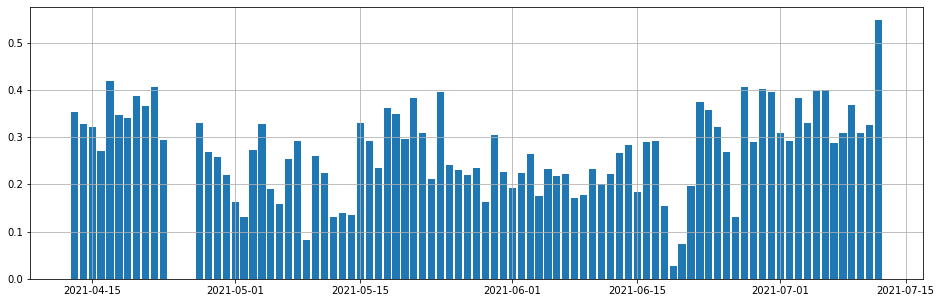

In [41]:
plt.figure(figsize=(16,5))
plt.bar(pd_trial_model.pos_scoring_date, pd_trial_model.rate)
plt.grid()
plt.show()

In [42]:
pd_trial_model.mean()

ba_total_cnt    145.263736
ba_model_cnt     34.494505
rate              0.263154
dtype: float64

In [43]:
pd_temp = temp.toPandas()
pd_temp["true"] = ~pd_temp["paid_date"].isna()*1
pd_temp["pred"] = ~pd_temp["group"].isna()*1

pd_temp.head()

,billing_account_id,pos_scoring_date,paid_date,group,scoring_date,date_modified,lead_status,true,pred
0,dn2029pc7lubu7c9kpbp,2021-05-06,None,None,None,None,None,0,0
1,dn205uvm2an5hcrtnki7,2021-05-31,None,None,None,None,None,0,0
2,dn208c3j1uhooqca4nqn,2021-05-06,None,None,None,None,None,0,0
3,dn208f665og3mue1ffoo,2021-06-16,2021-06-25,test,2021-06-16,2021-06-29,Recycled,1,1
4,dn209fra5ska66t181cf,2021-05-11,None,None,None,None,None,0,0


In [44]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score

In [45]:
print("Recall:    %5.3f" % recall_score(pd_temp["true"], pd_temp["pred"]))
print("Precision: %5.3f" % precision_score(pd_temp["true"], pd_temp["pred"]))
print("Gini:      %5.3f" % (-1+2*roc_auc_score(pd_temp["true"], pd_temp["pred"])))

Recall:    0.403
Precision: 0.167
Gini:      0.183


In [46]:
pd_temp[pd_temp["pred"]==0][["true"]].mean()

true    0.076984
dtype: float64

In [47]:
pd_temp.groupby("pred").agg([np.mean, np.sum])

true     
          mean  sum
pred               
0     0.076984  776
1     0.166614  523

In [48]:
spyt.stop(spark)